In [85]:
from time_series import Collection, find_ders, find_files
from brownian import logbin_func, abc_guess, psd_abc_func
import matplotlib.pyplot as plt
import numpy as np

In [73]:
base_der = "/mnt/ext/data"

In [74]:
date_ders = find_ders(base_der) # Experimental data is organized by date-collected
date_ders

['/mnt/ext/data/20201103',
 '/mnt/ext/data/20201111',
 '/mnt/ext/data/20201130',
 '/mnt/ext/data/20201204',
 '/mnt/ext/data/20201214',
 '/mnt/ext/data/20210113',
 '/mnt/ext/data/20210114',
 '/mnt/ext/data/20210120',
 '/mnt/ext/data/20210121',
 '/mnt/ext/data/20210202',
 '/mnt/ext/data/20210203',
 '/mnt/ext/data/20210208',
 '/mnt/ext/data/20210210',
 '/mnt/ext/data/20210408',
 '/mnt/ext/data/20210409',
 '/mnt/ext/data/20210412',
 '/mnt/ext/data/20210419',
 '/mnt/ext/data/20210517',
 '/mnt/ext/data/20210519']

In [75]:
date_der = date_ders[-1] # Select most recent date
run_ders = find_ders(date_der) # Further organized by a 'run name'
print(f"Available runs: {run_ders}")

Available runs: ['/mnt/ext/data/20210519/bead1', '/mnt/ext/data/20210519/bead2']


In [76]:
bead1 = find_ders(run_ders[0]) # Further organized by a 'run name'
bead2 = find_ders(run_ders[1])

In [113]:
XN = Collection("/mnt/ext/data/20210519/bead1/noise/trial_0.tdms", coord="x")
YN = Collection("/mnt/ext/data/20210519/bead1/noise/trial_0.tdms", coord="y")
CN = [XN, YN]

In [141]:
bead2

['/mnt/ext/data/20210519/bead2/F97',
 '/mnt/ext/data/20210519/bead2/F97_2',
 '/mnt/ext/data/20210519/bead2/F97_cold',
 '/mnt/ext/data/20210519/bead2/F97_V1.0',
 '/mnt/ext/data/20210519/bead2/F97_V1.1',
 '/mnt/ext/data/20210519/bead2/F97_V1.2',
 '/mnt/ext/data/20210519/bead2/F97_V1.3',
 '/mnt/ext/data/20210519/bead2/F97_V1.4',
 '/mnt/ext/data/20210519/bead2/F97_V1.5',
 '/mnt/ext/data/20210519/bead2/F97_V1.6',
 '/mnt/ext/data/20210519/bead2/F97_V1.7',
 '/mnt/ext/data/20210519/bead2/F97_V1.8',
 '/mnt/ext/data/20210519/bead2/F97_V1.8_shorter-records']

V: -0.0019753579115697143
Navg: 80


KeyError: "There is no channel named 'I' in group 'main' of the TDMS file"

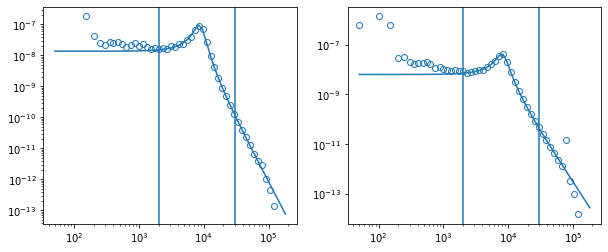

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fmin = 2e3
fmax = 3e4

for deri, der in enumerate(bead2[:1]):
    color = f"C{deri}"
    files = find_files(der)
    for file in files[:3]:
        X = Collection(file, coord="x")
        Y = Collection(file, coord="y")
        for Ci, C in enumerate([X, Y]):
            N = CN[Ci]
            C.apply("restore")
            C.apply("bin_average", Npts=64, inplace=True)
            C.average("PSD", noverlap=None, window="hann", taumax=20e-3, n_jobs=10)
            N.apply("restore")
            N.apply("bin_average", Npts=64, inplace=True)
            N.average("PSD", noverlap=None, window="hann", taumax=20e-3, n_jobs=10)
            if Ci == 0:
                print("V:", np.mean(C.Vs))
                print(f"Navg: {C.Navg_psd}")
            freq = C.freq
            psd = C.psd - N.psd
            mask = np.logical_and(freq<fmax, freq>fmin)
            abc0, pcov0 = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
            fplot = logbin_func(freq, func=np.mean, Npts=20)
            Pplot = logbin_func(psd, func=np.mean, Npts=20)
            axs[Ci].loglog(fplot, Pplot, marker="o", mfc="none", ls="none", mec=color)
            axs[Ci].loglog(fplot, psd_abc_func(fplot, *abc0), color=color)
            #axs[Ci].loglog(N.freq, N.psd, marker="o", ls="none")
            axs[Ci].axvline(fmin)
            axs[Ci].axvline(fmax)

V: -0.0019753579115697143
T: 25.236063364747835
Navg: 20
V: -0.0019952905089757737
T: 25.17825060820534
Navg: 20
V: 0.15620769614207403
T: 25.186179130737617
Navg: 20
V: 1.1043652529168457
T: 25.328104785302425
Navg: 20
V: 0.2110579235112245
T: 25.296451512995155
Navg: 20
V: -0.0019699877214919424
T: 25.321157106189666
Navg: 20
V: 0.8139995104526202
T: 25.355782422830526
Navg: 20
V: -0.0019840179478247005
T: 25.374331717488396
Navg: 20
V: 0.18065036836182696
T: 25.574049860432424
Navg: 20
V: 1.0458178367364002
T: 25.41539046805159
Navg: 20
V: 0.3210368485416513
T: 25.606437613204825
Navg: 20
V: 0.6191927175726362
T: 25.63125032092871
Navg: 60


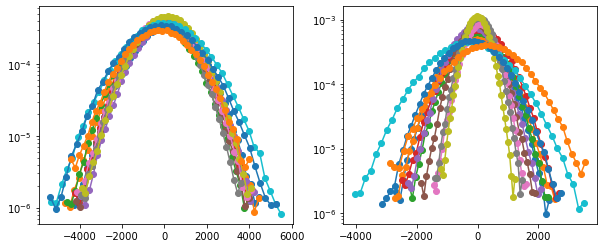

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for der in bead2[:]:
    files = find_files(der)
    for file in files[:1]:
        X = Collection(file, coord="vx", bin_average=256)
        Y = Collection(file, coord="vy", bin_average=256)
        for Ci, C in enumerate([X, Y]):
            C.average("HIST", n_jobs = 10)
            if Ci == 0:
                print("V:", np.mean(C.Vs))
                print("T:", np.mean(C.Ts))
                print(f"Navg: {C.Navg_hist}")
            axs[Ci].semilogy(C.bins, C.hist, marker="o")